<a href="https://colab.research.google.com/github/Kat-ies/Diploma/blob/encoder/Diploma_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Start**

In [ ]:
import os

!git clone https://github.com/Kat-ies/stylegan2-pytorch.git
os.chdir('/content/stylegan2-pytorch')

!git clone https://github.com/yuval-alaluf/restyle-encoder.git

!git clone https://github.com/eladrich/pixel2style2pixel.git

!pip install Ninja

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


PATH = '/content/drive/MyDrive/ДИ Диплом'
RESTYLE = '/content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt'
ENCODER = '/content/drive/MyDrive/ДИ Диплом/models/psp_ffhq_encode_original.pt'
STYLEGAN2 = '/content/drive/MyDrive/ДИ Диплом/models/stylegan2-ffhq-config-f-1024.pt'

Mounted at /content/drive


In [4]:
import torch
from torchvision import utils
from model import Generator
from tqdm import tqdm
from PIL import Image
import math
import torchvision.transforms as transforms


#global variables
LATENT_LEN = 512
DEVICE = 'cuda'
torch.manual_seed(42)
TRUNCATION = 0.7
IMG_SIZE = 1024

In [5]:
def transform(img):
    transf = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    return transf(img)

def init_generator(img_size=1024, latent_len=512, n_mlp=8, chanel_miltiplier=2, ckpt ='stylegan2-ffhq-config-f.pt', device='cuda', return_latent=True):
    g_ema = Generator(img_size, latent_len, n_mlp, channel_multiplier=chanel_miltiplier).to(device)
    checkpoint = torch.load(ckpt)
    g_ema.load_state_dict(checkpoint["g_ema"], strict=False)
    return g_ema

def get_image(method, img_path=None, need_transform=True,
              return_latent=False, img_size=IMG_SIZE,
              ckpt=STYLEGAN2, latent_len=LATENT_LEN, 
              truncation=TRUNCATION, device=DEVICE, img_name='input.png'):
    if method == 'custom_image':
        image = Image.open(img_path)
        image.save(img_name)

    elif method == 'random_latent' or method == 'average_latent':
        torch.manual_seed(42)
        generator = init_generator(ckpt = ckpt, img_size=img_size)
        trunc = generator.mean_latent(int(math.log(img_size, 2)) * 2 - 2)

        sample_z = torch.randn(1, latent_len, dtype=torch.float32, device=torch.device(device)).uniform_(-1, 1)
        if method == 'average_latent':
            latent_w = generator.mean_latent(int(math.log(img_size, 2)) * 2 - 2)
        else:
            latent_w = torch.tensor(generator.get_latent(sample_z))
        input_image, input_latent = generator([latent_w], truncation=truncation, truncation_latent=trunc, input_is_latent=True, return_latents=True)

        utils.save_image(
        input_image,
        img_name,
        nrow=1,
        normalize=True,
        range=(-1, 1))

    else:
        print('method', method, 'not supported')
        return None

    input_image = Image.open(img_name).resize((256, 256))
    if need_transform:
        input_image = transform(input_image)
    input_image.to(device)
    if method != 'custom_image' and return_latent:
        return input_image, input_latent
    else: 
        return input_image

In [6]:
import os

os.chdir('/content/stylegan2-pytorch/restyle-encoder')
from models.psp import pSp as pspRestyle

os.chdir('../pixel2style2pixel')
from models.psp import pSp as psp
from criteria.lpips.lpips import LPIPS

os.chdir('../')
print(os.getcwd())

if not os.path.isdir("results"):
     os.mkdir("results")

/content/stylegan2-pytorch


#**Examples**
here there're 3 pictures (custom_image, from random latent, from mean_latent) for getting their latent code

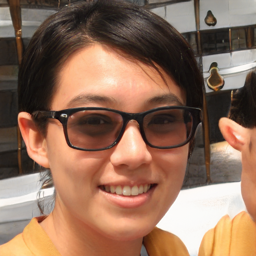

In [7]:
rand_img = get_image('random_latent', img_name='random_latent.png')
res = Image.open('random_latent.png').resize((256, 256))
res

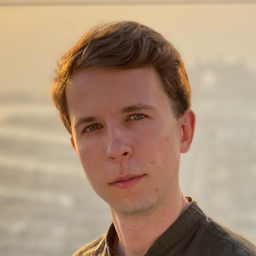

In [56]:
custom_img = get_image('custom_image', img_path='/content/drive/MyDrive/ДИ Диплом/data/vitya.jpg', img_name='custom.png')
res = Image.open('custom.png').resize((256, 256))
res

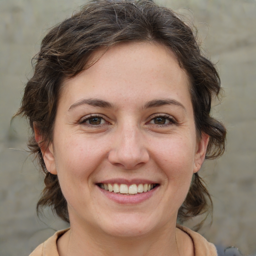

In [9]:
average_img = get_image('average_latent', img_name='average_latent.png')
res = Image.open('average_latent.png').resize((256, 256))
res

#**New part**
Here we will test encoder for our input images

In [28]:
import os
import torch
import pprint
from argparse import Namespace


def get_opts(method=RESTYLE, iters=5, encoder='BackboneEncoder'):
    params = torch.load(method, map_location='cpu')
    opts = params['opts']
    opts['encoder_type'] = encoder
    # for restyle
    opts['checkpoint_path'] = method
    opts['n_iters_per_batch'] = iters
    opts['resize_outputs'] = False #generate images in full resolution
    # for original psp
    opts['output_size'] = 1024
    opts['learn_in_w'] = False
    #pprint.pprint(opts)
    return Namespace(**opts)


In [11]:
import sys
sys.path.append('.')
sys.path.append('..')

In [12]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla K80


In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_pictures(input_img='input.png', cols=3, rows=3):
    images = []

    res_dir = 'results'
    list_dirs = os.listdir(res_dir)
    list_dirs.sort()
    for cur_file in list_dirs:
        images.append(Image.open(os.path.join(res_dir, cur_file)))
    images.append(Image.open(input_img).convert("RGB"))

    fig = plt.figure(figsize=(10, rows * 2))
    ax = []

    for i in range(cols * rows):
        if i < len(images):
            image = images[i]
            ax.append(fig.add_subplot(rows, cols, i + 1))
            plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.show()

In [53]:
import torch
import time


def save_images(images, folder='results'):
    for i, image in enumerate(images):
        utils.save_image(image, f"{folder}/{str(i).zfill(6)}.png", nrow=1, normalize=True, range=(-1, 1))

def run(inputs, net, mode, opts=None, avg_image=None, return_img=False):
    if mode == 'encoder':
        results_batch, results_latent = net(inputs, randomize_noise=False, return_latents=True)

        def tensor2im(var):
            var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
            var = ((var + 1) / 2)
            var[var < 0] = 0
            var[var > 1] = 1
            var = var * 255
            return var.astype('uint8')
        tmp = Image.fromarray(tensor2im(results_batch[0]))
        tmp.save('results/000000.png')

    elif mode == 'restyle':
        y_hat, latent = None, None
        results_batch = {idx: [] for idx in range(inputs.shape[0])}
        results_latent = {idx: [] for idx in range(inputs.shape[0])}
        for iter in range(opts.n_iters_per_batch):
            if iter == 0:
                avg_image_for_batch = avg_image.unsqueeze(0).repeat(inputs.shape[0], 1, 1, 1)
                x_input = torch.cat([inputs, avg_image_for_batch], dim=1)
            else:
                x_input = torch.cat([inputs, y_hat], dim=1)

            y_hat, latent = net.forward(x_input, latent=latent, randomize_noise=False, return_latents=True, resize=opts.resize_outputs)

            # store intermediate outputs
            for idx in range(inputs.shape[0]):
                results_batch[idx].append(y_hat[idx])
                results_latent[idx].append(latent[idx].cpu().numpy())

            # resize input to 256 before feeding into next iteration
            y_hat = net.face_pool(y_hat)

            # [0] because it's a dict
            save_images(results_batch[0])

    else:
        print('mode', mode, 'not supported!')
        return None

    return results_batch[0]

In [48]:
def clear_folder():
    os.system('rm -f /content/stylegan2-pytorch/results/*')

def get_net(opts, mode):
    if mode == 'restyle':
        net = pspRestyle(opts)
    elif mode == 'encoder':
        net = psp(opts)
    else:
        print('mode', mode, 'not supported!')
        return None

    net.eval()
    net.cuda()
    print('Model successfully loaded!')
    return net

In [16]:
from torch import nn

# for PIL images
def calc_L2(input_img, output_img):
    input_img = transform(input_img)
    output_img = transform(output_img)
    loss_fn = nn.MSELoss()
    return loss_fn(input_img.to(DEVICE), output_img.to(DEVICE))

def calc_LPIPS(input_img, output_img):
    input_img = transform(input_img)
    output_img = transform(output_img)
    loss_fn = LPIPS(net_type='alex')
    return loss_fn(input_img.to(DEVICE), output_img.to(DEVICE))

# **Run on 3 image types**

## **Run on image from average latent (original pSp only)**

In [57]:
input_img = average_img

options = get_opts(method=ENCODER, encoder='GradualStyleEncoder')
net = get_net(options, 'encoder')

with torch.no_grad():
    clear_folder()
    tic = time.time()
    result = run(input_img.unsqueeze(0).cuda().float(), net, 'encoder')
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/psp_ffhq_encode_original.pt
Model successfully loaded!
Inference took 0.5539 seconds.


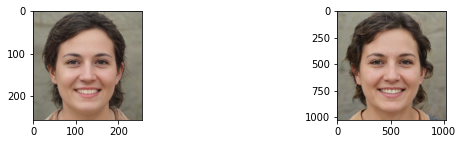

In [58]:
plot_pictures('average_latent.png',cols=2, rows=1)

## **Run on image from average latent (pSp with restyle)**

In [59]:
input_img = average_img

options = get_opts(method=RESTYLE, encoder='BackboneEncoder')
restyle_net = get_net(options, 'restyle')

with torch.no_grad():
    clear_folder()
    avg_image = get_image('average_latent').to(DEVICE).float().detach()
    tic = time.time()
    result = run(input_img.unsqueeze(0).cuda(), restyle_net, 'restyle', options, avg_image)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 10.1444 seconds.


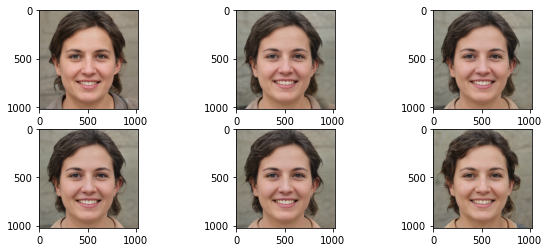

In [60]:
plot_pictures('average_latent.png',cols=3, rows=2)

## **Run on image from random latent (original pSp only)**

In [61]:
input_img = rand_img

options = get_opts(method=ENCODER, encoder='GradualStyleEncoder')
net = get_net(options, 'encoder')

with torch.no_grad():
    clear_folder()
    tic = time.time()
    result = run(input_img.unsqueeze(0).cuda().float(), net, 'encoder')
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/psp_ffhq_encode_original.pt
Model successfully loaded!
Inference took 0.5920 seconds.


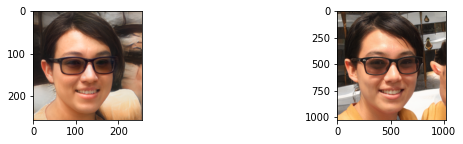

In [62]:
plot_pictures('random_latent.png',cols=2, rows=1)

## **Run on image from random latent (pSp with restyle)**

In [63]:
input_img = rand_img

options = get_opts(method=RESTYLE, encoder='BackboneEncoder')
restyle_net = get_net(options, 'restyle')

with torch.no_grad():
    clear_folder()
    avg_image = get_image('average_latent').to(DEVICE).float().detach()
    tic = time.time()
    result = run(input_img.unsqueeze(0).cuda(), restyle_net, 'restyle', options, avg_image)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 10.7187 seconds.


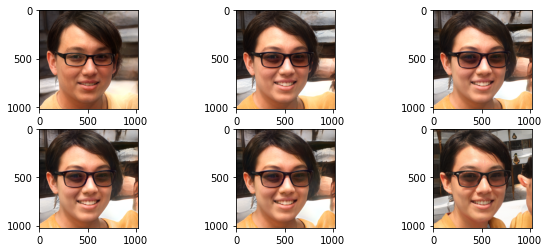

In [64]:
plot_pictures('random_latent.png',cols=3, rows=2)

## **Run on custom image (original pSp only)**

In [65]:
input_img = custom_img

options = get_opts(method=ENCODER, encoder='GradualStyleEncoder')
net = get_net(options, 'encoder')

with torch.no_grad():
    clear_folder()
    tic = time.time()
    result = run(input_img.unsqueeze(0).cuda().float(), net, 'encoder')
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/psp_ffhq_encode_original.pt
Model successfully loaded!
Inference took 0.4128 seconds.


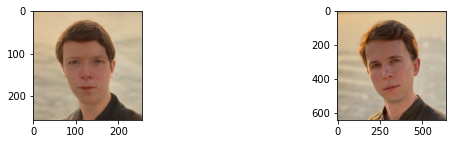

In [66]:
plot_pictures('custom.png',cols=2, rows=1)

## **Run on custom image (pSp with restyle)**

In [67]:
input_img = custom_img

options = get_opts(method=RESTYLE, encoder='BackboneEncoder')
restyle_net = get_net(options, 'restyle')

with torch.no_grad():
    clear_folder()
    avg_image = get_image('average_latent').to(DEVICE).float().detach()
    tic = time.time()
    result = run(input_img.unsqueeze(0).cuda(), restyle_net, 'restyle', options, avg_image)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 11.4420 seconds.


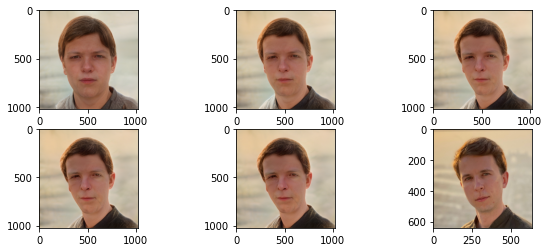

In [68]:
plot_pictures('custom.png', cols=3, rows=2)

#**Big experiments**
here we will run all algorithm with different params to make a diff table (runned code will be in next block)

In [77]:
import pandas as pd


df = pd.DataFrame(results, columns=['type','average_latent', 'random_latent', 'custom_image'])

In [78]:
df

type  \
0          original psp with GradualStyleEncoder   
1   restyle psp with GradualStyleEncoder 5 iters   
2   restyle psp with GradualStyleEncoder 3 iters   
3   restyle psp with GradualStyleEncoder 5 iters   
4  restyle psp with GradualStyleEncoder 10 iters   
5       restyle psp with BackboneEncoder 3 iters   
6       restyle psp with BackboneEncoder 5 iters   
7      restyle psp with BackboneEncoder 10 iters   

                               average_latent  \
0   L2:  0.0156 LPIPS:  0.0352 time: 0.5373s.   
1  L2:  0.0629 LPIPS:  0.0638 time: 10.6907s.   
2   L2:  0.0647 LPIPS:  0.0777 time: 4.6736s.   
3  L2:  0.0708 LPIPS:  0.0734 time: 10.3940s.   
4  L2:  0.1936 LPIPS:  0.1270 time: 35.0705s.   
5   L2:  0.0132 LPIPS:  0.0269 time: 4.0134s.   
6   L2:  0.0114 LPIPS:  0.0256 time: 9.2367s.   
7  L2:  0.0114 LPIPS:  0.0271 time: 31.5679s.   

                                random_latent  \
0   L2:  0.0578 LPIPS:  0.0747 time: 0.5334s.   
1  L2:  0.2021 LPIPS:  0.1431 time: 11.4101s.   
2   L2:  0.2120 LPIPS:  0.1350 time: 4.5414s.   
3  L2:  0.2021 LPIPS:  0.1431 time: 10.5266s.   
4  L2:  0.2759 LPIPS:  0.2043 time: 35.0987s.   
5   L2:  0.0541 LPIPS:  0.0566 time: 4.3057s.   
6   L2:  0.0493 LPIPS:  0.0547 time: 9.8509s.   
7  L2:  0.0482 LPIPS:  0.0559 time: 33.2271s.   

                                 custom_image  
0   L2:  0.0177 LPIPS:  0.0442 time: 0.4399s.  
1  L2:  0.2433 LPIPS:  0.1468 time: 10.7039s.  
2   L2:  0.2343 LPIPS:  0.1391 time: 4.3600s.  
3  L2:  0.2433 LPIPS:  0.1468 time: 10.0547s.  
4  L2:  0.3223 LPIPS:  0.1940 time: 32.9803s.  
5   L2:  0.0193 LPIPS:  0.0426 time: 3.9088s.  
6   L2:  0.0160 LPIPS:  0.0362 time: 8.7772s.  
7  L2:  0.0144 LPIPS:  0.0350 time: 29.1523s.

## **Code for Big experiments**

In [69]:
results = []

In [72]:
one_row = []

one_row.append('original psp with GradualStyleEncoder')

imgs = [average_img, rand_img, custom_img]
imgs_path = [ 'average_latent.png', 'random_latent.png', 'custom.png']

for i, input_img in enumerate(imgs):
    print('img number', i)
    options = get_opts(method=ENCODER, encoder='GradualStyleEncoder')
    net = get_net(options, 'encoder')

    with torch.no_grad():
        clear_folder()
        tic = time.time()
        result = run(input_img.unsqueeze(0).cuda().float(), net, 'encoder')
        toc = time.time()
        print('Inference took {:.4f} seconds.'.format(toc - tic))


        res_dir = 'results'
        list_dirs = os.listdir(res_dir)
        list_dirs.sort()

        in_ = Image.open(imgs_path[i])
        out_ = Image.open(os.path.join(res_dir, list_dirs[-1]))

        l2 = calc_L2(in_, out_).cpu().numpy()
        print('L2 loss', l2)

        lpips = calc_LPIPS(in_, out_).cpu().numpy()
        print('LPIPS loss', lpips)

        out_str = ('L2: ') + '{: 0.4f}'.format(l2) + ' LPIPS: ' + '{: 0.4f}'.format(lpips) + ' time: ' + '{:.4f}s.'.format(toc - tic)
        one_row.append(out_str)
        print(out_str)
results.append(one_row)

img number 0
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/psp_ffhq_encode_original.pt
Model successfully loaded!
Inference took 0.5373 seconds.
L2 loss 0.01555148


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

LPIPS loss 0.03516809
L2:  0.0156 LPIPS:  0.0352 time: 0.5373s.
img number 1
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/psp_ffhq_encode_original.pt
Model successfully loaded!
Inference took 0.5334 seconds.
L2 loss 0.057840865
LPIPS loss 0.07467678
L2:  0.0578 LPIPS:  0.0747 time: 0.5334s.
img number 2
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/psp_ffhq_encode_original.pt
Model successfully loaded!
Inference took 0.4399 seconds.
L2 loss 0.01773797
LPIPS loss 0.044164967
L2:  0.0177 LPIPS:  0.0442 time: 0.4399s.


restyle psp with GradualStyleEncoder 3 iters
img number 0
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 4.6736 seconds.


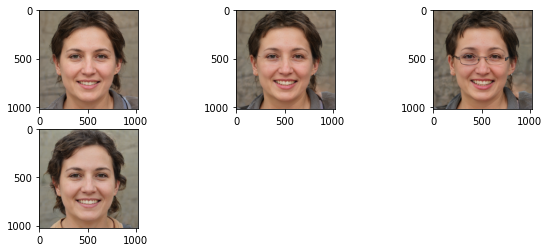

L2 loss 0.06474371
LPIPS loss 0.077735424
L2:  0.0647 LPIPS:  0.0777 time: 4.6736s.
img number 1
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 4.5414 seconds.


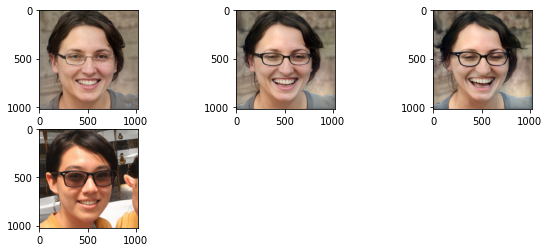

L2 loss 0.21204245
LPIPS loss 0.13498238
L2:  0.2120 LPIPS:  0.1350 time: 4.5414s.
img number 2
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 4.3600 seconds.


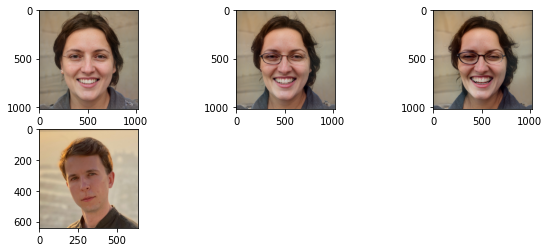

L2 loss 0.2343205
LPIPS loss 0.13911343
L2:  0.2343 LPIPS:  0.1391 time: 4.3600s.
restyle psp with GradualStyleEncoder 5 iters
img number 0
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 10.3940 seconds.


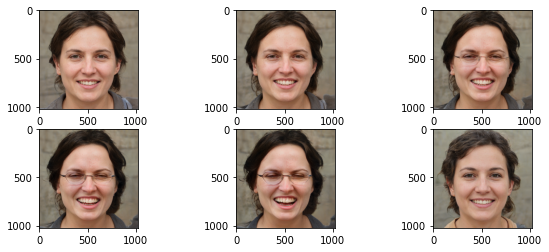

L2 loss 0.07080485
LPIPS loss 0.07340478
L2:  0.0708 LPIPS:  0.0734 time: 10.3940s.
img number 1
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 10.5266 seconds.


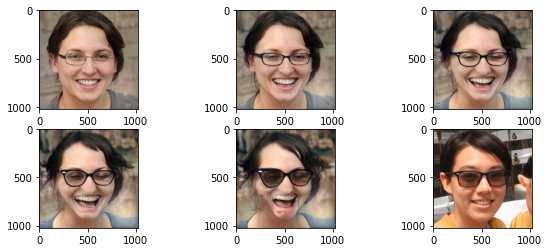

L2 loss 0.20213722
LPIPS loss 0.14314467
L2:  0.2021 LPIPS:  0.1431 time: 10.5266s.
img number 2
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 10.0547 seconds.


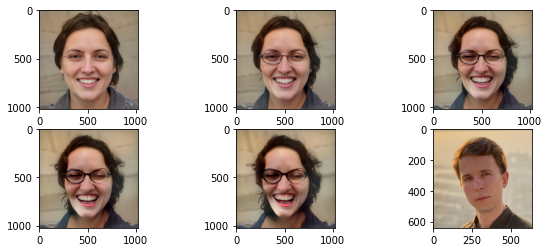

L2 loss 0.24333927
LPIPS loss 0.14678693
L2:  0.2433 LPIPS:  0.1468 time: 10.0547s.
restyle psp with GradualStyleEncoder 10 iters
img number 0
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 35.0705 seconds.


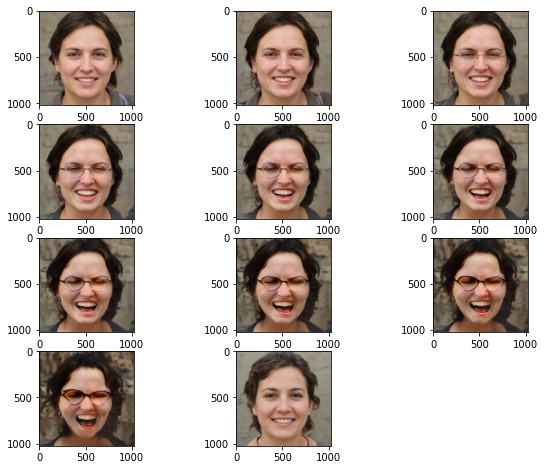

L2 loss 0.19355583
LPIPS loss 0.1269574
L2:  0.1936 LPIPS:  0.1270 time: 35.0705s.
img number 1
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 35.0987 seconds.


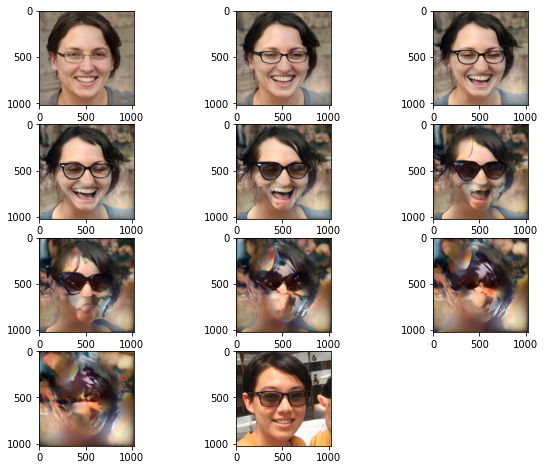

L2 loss 0.27588892
LPIPS loss 0.20427184
L2:  0.2759 LPIPS:  0.2043 time: 35.0987s.
img number 2
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 32.9803 seconds.


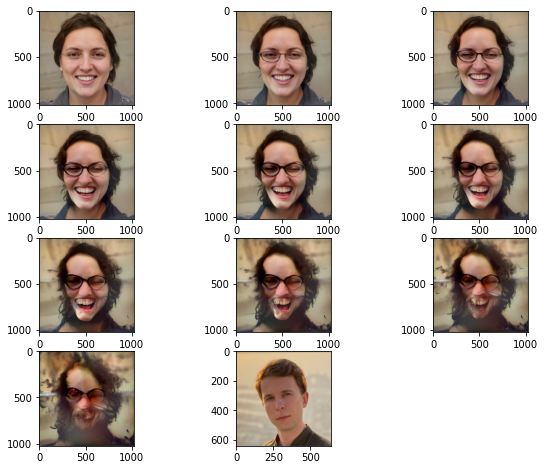

L2 loss 0.3222777
LPIPS loss 0.19402304
L2:  0.3223 LPIPS:  0.1940 time: 32.9803s.


In [75]:
imgs = [average_img, rand_img, custom_img]
imgs_path = [ 'average_latent.png', 'random_latent.png', 'custom.png']
iters = [3, 5, 10]

for iter in iters:
    one_row = []
    title = 'restyle psp with GradualStyleEncoder ' + str(iter) + ' iters'
    one_row.append(title)
    print(title)
    for i, input_img in enumerate(imgs):
        print('img number', i)
        options = get_opts(method=RESTYLE, encoder='GradualStyleEncoder', iters=iter)
        restyle_net = get_net(options, 'restyle')

        with torch.no_grad():
            clear_folder()
            avg_image = get_image('average_latent').to(DEVICE).float().detach()
            tic = time.time()
            result = run(input_img.unsqueeze(0).cuda(), restyle_net, 'restyle', options, avg_image)
            toc = time.time()
            print('Inference took {:.4f} seconds.'.format(toc - tic))

            plot_pictures(imgs_path[i], cols=3, rows=iter//3 + 1)
        
            res_dir = 'results'
            list_dirs = os.listdir(res_dir)
            list_dirs.sort()

            in_ = Image.open(imgs_path[i])
            out_ = Image.open(os.path.join(res_dir, list_dirs[-1]))

            l2 = calc_L2(in_, out_).cpu().numpy()
            print('L2 loss', l2)

            lpips = calc_LPIPS(in_, out_).cpu().numpy()
            print('LPIPS loss', lpips)

            out_str = ('L2: ') + '{: 0.4f}'.format(l2) + ' LPIPS: ' + '{: 0.4f}'.format(lpips) + ' time: ' + '{:.4f}s.'.format(toc - tic)
            one_row.append(out_str)
            print(out_str)
    results.append(one_row)

restyle psp with BackboneEncoder 3 iters
img number 0
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 4.0134 seconds.


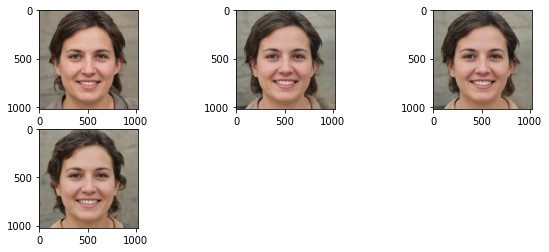

L2 loss 0.013233118
LPIPS loss 0.026941407
L2:  0.0132 LPIPS:  0.0269 time: 4.0134s.
img number 1
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 4.3057 seconds.


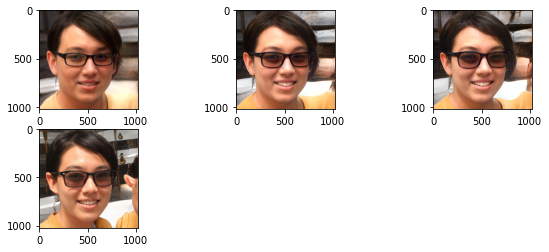

L2 loss 0.054061335
LPIPS loss 0.05655358
L2:  0.0541 LPIPS:  0.0566 time: 4.3057s.
img number 2
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 3.9088 seconds.


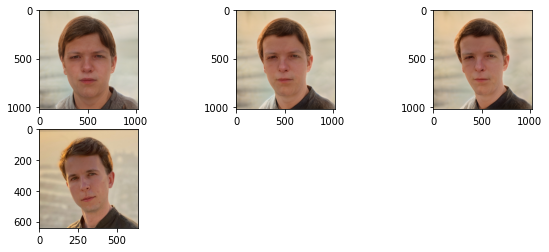

L2 loss 0.019269537
LPIPS loss 0.04259806
L2:  0.0193 LPIPS:  0.0426 time: 3.9088s.
restyle psp with BackboneEncoder 5 iters
img number 0
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 9.2367 seconds.


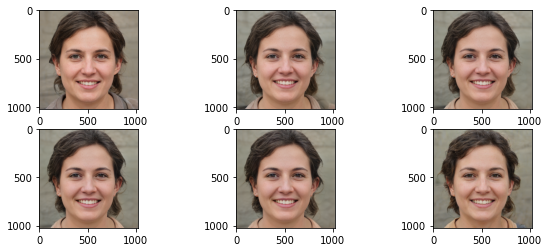

L2 loss 0.011433616
LPIPS loss 0.025597822
L2:  0.0114 LPIPS:  0.0256 time: 9.2367s.
img number 1
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 9.8509 seconds.


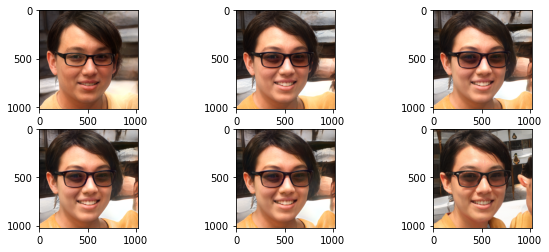

L2 loss 0.049294364
LPIPS loss 0.05469064
L2:  0.0493 LPIPS:  0.0547 time: 9.8509s.
img number 2
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 8.7772 seconds.


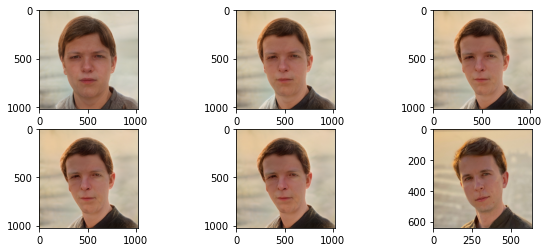

L2 loss 0.015979141
LPIPS loss 0.036222257
L2:  0.0160 LPIPS:  0.0362 time: 8.7772s.
restyle psp with BackboneEncoder 10 iters
img number 0
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 31.5679 seconds.


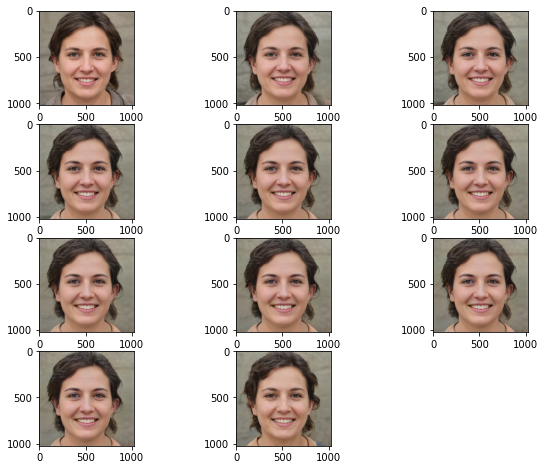

L2 loss 0.011401082
LPIPS loss 0.027092686
L2:  0.0114 LPIPS:  0.0271 time: 31.5679s.
img number 1
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 33.2271 seconds.


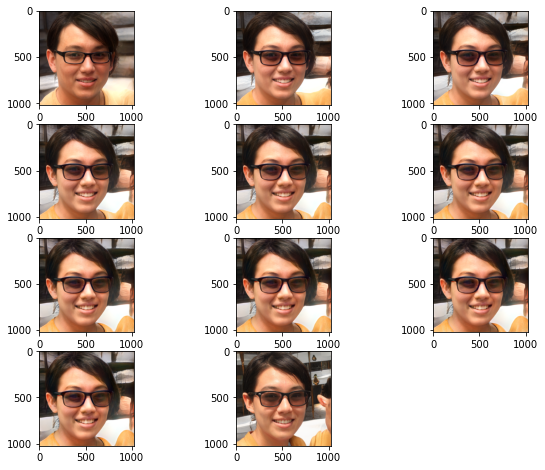

L2 loss 0.048189014
LPIPS loss 0.055879258
L2:  0.0482 LPIPS:  0.0559 time: 33.2271s.
img number 2
Loading ReStyle pSp from checkpoint: /content/drive/MyDrive/ДИ Диплом/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!
Inference took 29.1523 seconds.


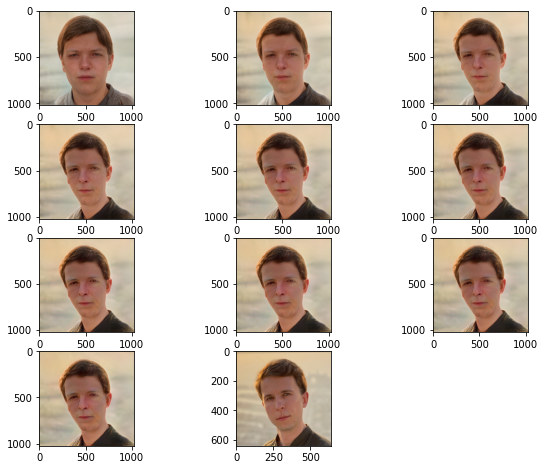

L2 loss 0.014392853
LPIPS loss 0.03501746
L2:  0.0144 LPIPS:  0.0350 time: 29.1523s.


In [76]:
imgs = [average_img, rand_img, custom_img]
imgs_path = [ 'average_latent.png', 'random_latent.png', 'custom.png']
iters = [3, 5, 10]

for iter in iters:
    one_row = []
    title = 'restyle psp with BackboneEncoder ' + str(iter) + ' iters'
    one_row.append(title)
    print(title)
    for i, input_img in enumerate(imgs):
        print('img number', i)
        options = get_opts(method=RESTYLE, encoder='BackboneEncoder', iters=iter)
        restyle_net = get_net(options, 'restyle')

        with torch.no_grad():
            clear_folder()
            avg_image = get_image('average_latent').to(DEVICE).float().detach()
            tic = time.time()
            result = run(input_img.unsqueeze(0).cuda(), restyle_net, 'restyle', options, avg_image)
            toc = time.time()
            print('Inference took {:.4f} seconds.'.format(toc - tic))

            plot_pictures(imgs_path[i], cols=3, rows=iter//3 + 1)
        
            res_dir = 'results'
            list_dirs = os.listdir(res_dir)
            list_dirs.sort()

            in_ = Image.open(imgs_path[i])
            out_ = Image.open(os.path.join(res_dir, list_dirs[-1]))

            l2 = calc_L2(in_, out_).cpu().numpy()
            print('L2 loss', l2)

            lpips = calc_LPIPS(in_, out_).cpu().numpy()
            print('LPIPS loss', lpips)

            out_str = ('L2: ') + '{: 0.4f}'.format(l2) + ' LPIPS: ' + '{: 0.4f}'.format(lpips) + ' time: ' + '{:.4f}s.'.format(toc - tic)
            one_row.append(out_str)
            print(out_str)
    results.append(one_row)